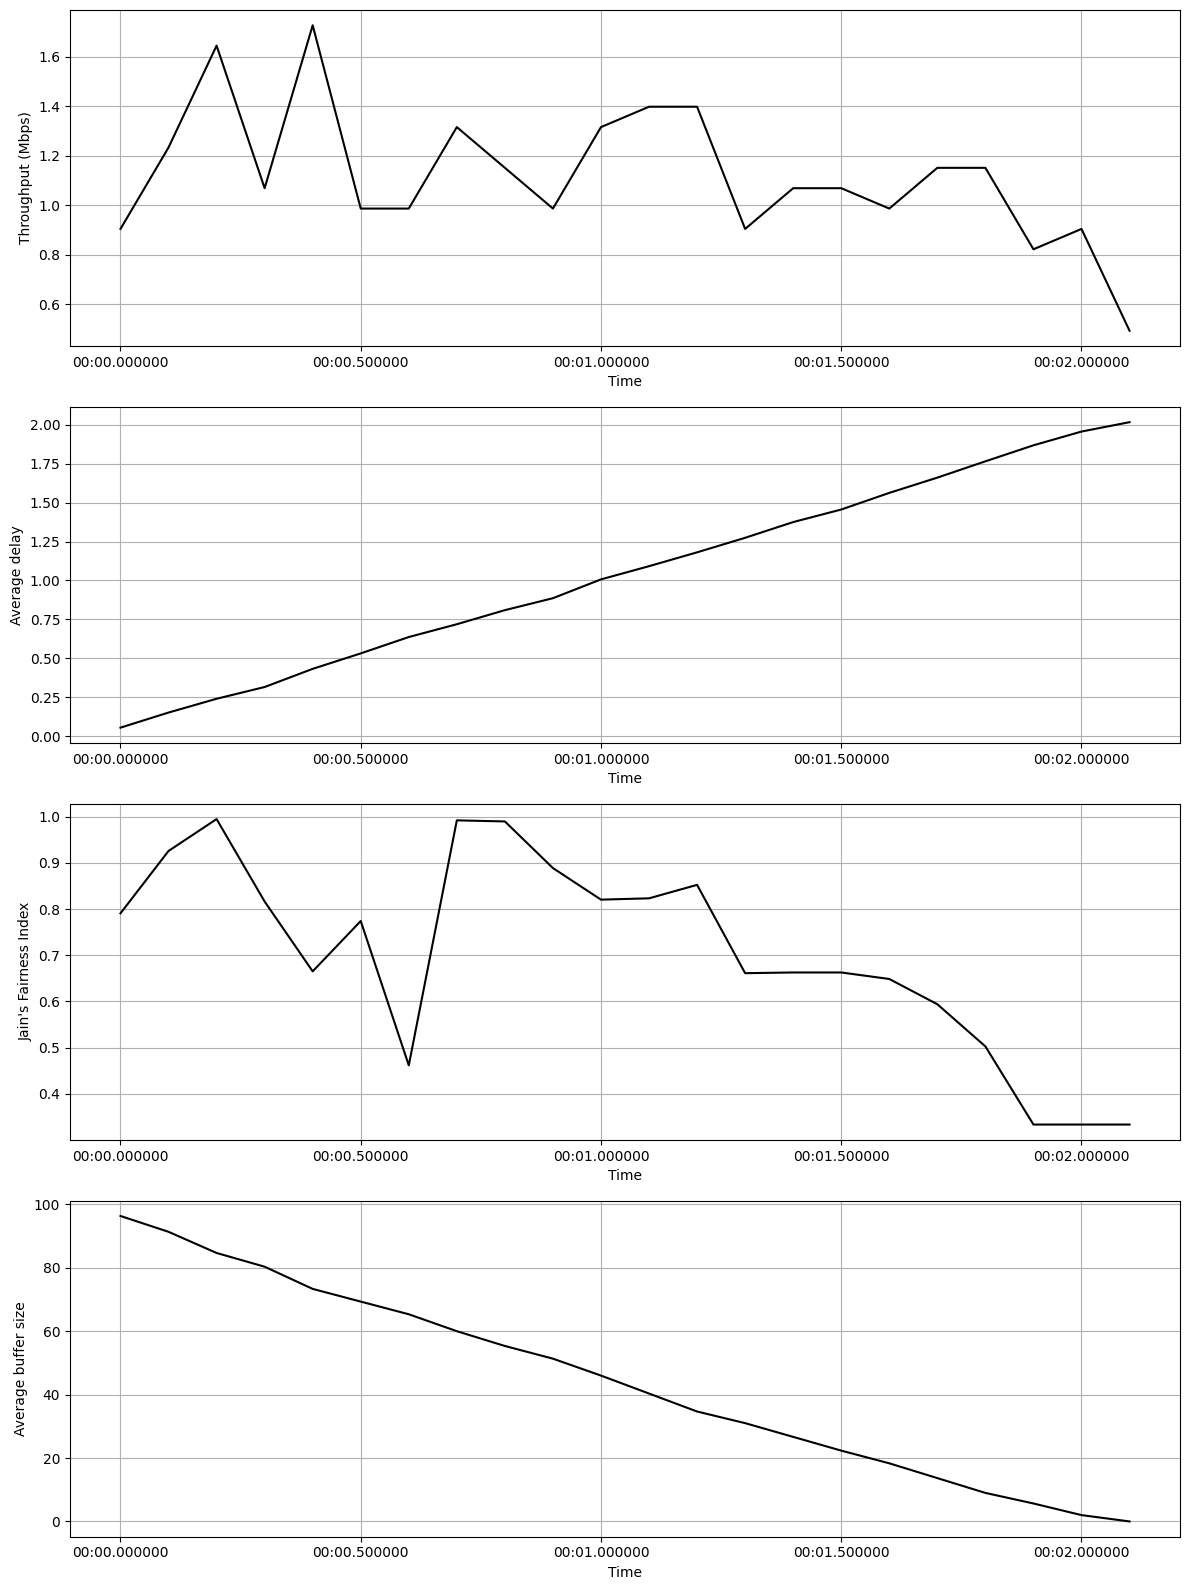

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

delta = '0.1s'

# Load the CSV file into a DataFrame
df = pd.read_csv("aloha.tr", sep="\s+", names  = ["event", "time", "node", "delay", "size"])

# Assume 'time' is in seconds, convert it to a datetime format using an arbitrary start time
df['time'] = pd.to_datetime(df['time'], unit='s', origin='unix')

# Set 'time' as the DataFrame index
df.set_index('time', inplace=True)

# Create a subplot for each event type plus one for the 'buffer size', one for Jain's fairness index, and one for total 'r' events
fig, axs = plt.subplots(4, 1, figsize=(12, 4 * (4)), sharex=False)



throughput_total_df = df[df['event'] == 'r']['size'].resample(delta).sum()  # Total 'r' events per time
throughput_total_df = throughput_total_df * 8 / (delta / pd.Timedelta('1s')) / 1e6 
axs[0].plot(throughput_total_df, color='black')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Throughput (Mbps)')
axs[0].grid(True)


resampled_delay_df = df[df.event == 'r'].groupby([pd.Grouper(freq=delta), 'node']).mean(numeric_only=True)
resampled_delay_df = resampled_delay_df.groupby('time').mean()
axs[1].plot(resampled_delay_df['delay'], color='black')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average delay')
axs[1].grid(True)





# Calculate Jain's fairness index 
def jains_fairness_index(counts):
    total = counts.sum()
    if total == 0:
        return 1
    squared_sum = (counts ** 2).sum()
    n = len(counts)
    return (total ** 2) / (n * squared_sum)

# Combine all events to calculate fairness index
resampled_r_df = df[df['event'] == 'r'].groupby('node').resample(delta).size().reset_index(name='r_count')
pivot_r_df = resampled_r_df.pivot(index='time', columns='node', values='r_count').fillna(0)
fairness_indices = pivot_r_df.apply(jains_fairness_index, axis=1)

# Plot Jain's fairness index in the second to last subplot
axs[2].plot(fairness_indices.index, fairness_indices, label='Jain\'s Fairness Index', color='black', linestyle='-')

axs[2].set_xlabel('Time')
axs[2].set_ylabel('Jain\'s Fairness Index')
axs[2].grid(True)





# Calculate and plot buffer size
plus_resampled_df = df[df['event'] == '+'].groupby('node').resample(delta).size().reset_index(name='event_count')
r_resampled_df = df[df['event'] == 'r'].groupby('node').resample(delta).size().reset_index(name='event_count')

plus_pivot_df = plus_resampled_df.pivot(index='time', columns='node', values='event_count').fillna(0)
r_pivot_df = r_resampled_df.pivot(index='time', columns='node', values='event_count').fillna(0)

plus_count_df = df[df['event'] == '+'].groupby('node').resample(delta).size().reset_index(name='plus_count')
pivot_plus_df = plus_count_df.pivot(index='time', columns='node', values='plus_count').fillna(0)
buffer_sizes = pivot_plus_df.sub(pivot_r_df, fill_value=0)

numNodes = len(buffer_sizes.columns)
for i in range(numNodes):
    buffer_sizes[f'current_size_{i+1}'] = 0

for node in range(1,numNodes+1):
    for i, time in enumerate(buffer_sizes.index):
        if i == 0:
            # For the first interval, buffer size is based on the initial buffer size
            buffer_sizes.at[time, f'current_size_{node}'] = buffer_sizes.at[time, node]
        else:
            # For other intervals, buffer size is based on the previous interval
            prevTime = prev_time = buffer_sizes.index[i-1]
            buffer_sizes.at[time, f'current_size_{node}'] = buffer_sizes.at[prevTime, f'current_size_{node}'] + buffer_sizes.at[time, node] 

node_buffer_strs = [str(column) for column in buffer_sizes.columns if str(column).startswith("current_size")]
buffer_sizes['sum'] = buffer_sizes[node_buffer_strs].mean(axis=1)

axs[3].plot(buffer_sizes['sum'], color='black')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Average buffer size')
axs[3].grid(True)






plt.tight_layout()
plt.show()
